### DeepAR Model - Bike Rental Prediction

In [1]:
import numpy as np
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import datetime

In [3]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [19]:
# provide endpoint

endpoint_name = 'deepar-biketrain-no-categories-2024-06-06-13-20-47-915'


In [4]:
with_categories = False
freq = "H"
prediction_length = 288
context_length = 288

In [59]:
dt_predict_max = pd.Timestamp("2012-12-31 23:00:00", freq=freq) # 2012-12-31 23:00 alt way..pd.datetime(2012,12,31,23,0,0)

dt_dataset_start_time = pd.Timestamp("2011-01-01 00:00:00", freq=freq)
dt_dataset_end_time = pd.Timestamp("2012-12-19 23:00:00", freq=freq)

# use for model training
# start time is the first row provided by kaggle
# training TS end time ensures some data is withheld for model testing
# 12 days worth of training data is withheld for testing

dt_training_range = (dt_dataset_start_time, dt_dataset_end_time - datetime.timedelta(hours=2*24))

# use entire data for testing
# We can compare predicted values vs actual
dt_test_range = (dt_dataset_start_time, dt_dataset_end_time)

/tmp/ipykernel_10708/3291106326.py:1: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  dt_predict_max = pd.Timestamp("2012-12-31 23:00:00", freq=freq) # 2012-12-31 23:00 alt way..pd.datetime(2012,12,31,23,0,0)
/tmp/ipykernel_10708/3291106326.py:3: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  dt_dataset_start_time = pd.Timestamp("2011-01-01 00:00:00", freq=freq)
/tmp/ipykernel_10708/3291106326.py:4: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  dt_dataset_end_time = pd.Timestamp("2012-12-19 23:00:00", freq=freq)


In [6]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()

In [7]:
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]  

def encode_dynamic_feat(dynamic_feat):  
    l = []
    for col in dynamic_feat:
        assert (not dynamic_feat[col].isna().any()), col  + ' has NaN'             
        l.append(dynamic_feat[col].tolist())
    return l

def series_to_obj(ts, cat=None, dynamic_feat=None):
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = encode_dynamic_feat(dynamic_feat)
    return obj

def series_to_jsonline(ts, cat=None, dynamic_feat=None):
    return json.dumps(series_to_obj(ts, cat, dynamic_feat))      

In [8]:
# SDK 2. RealTimePredictor renamed to Predictor
class DeepARPredictor(sagemaker.predictor.Predictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        #prediction_times = [x.index[-1]+1 for x in ts]
        prediction_times = [x.index[-1] + datetime.timedelta(hours=1) for x in ts] 
        
        req = self.__encode_request(ts, cat, dynamic_feat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, dynamic_feat, encoding, num_samples, quantiles):
        
        instances = [series_to_obj(ts[k], 
                                   cat[k] if cat else None,
                                   dynamic_feat if dynamic_feat else None) 
                     for k in range(len(ts))]
        
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            #prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            prediction_index = pd.date_range(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [60]:
# SDK 2 parameter name endpoint_name, contentepype is specified as part of the serializer

predictor = DeepARPredictor(
    endpoint_name = endpoint_name,
    sagemaker_session=sagemaker_session
)

predictor.set_prediction_parameters(freq, prediction_length)
predictor.serializer.content_type = 'application/json'


In [61]:
df = pd.read_csv('all_data.csv', parse_dates=['datetime'],index_col=0)
df_test = pd.read_csv('test.csv', parse_dates = ['datetime'], index_col=0)
df = df.resample('1h').mean()

In [62]:
df.index[:5]

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00'],
              dtype='datetime64[ns]', name='datetime', freq='H')

In [63]:
df.shape

(17256, 11)

In [64]:
target_values = ['count','registered','casual']
time_series_test = []
time_series_training = []

for t in target_values:
    time_series_test.append(df[dt_test_range[0]:dt_test_range[1]][t])
    time_series_training.append(df[dt_training_range[0]:dt_training_range[1]][t])

In [65]:
# Provide 0 based index for categories

list_of_df = predictor.predict(time_series_training,
                              cat = [[0],[1],[2]] if with_categories else None)

In [66]:
list_of_df

[                           0.1         0.5         0.9
 2012-12-18 00:00:00   3.469997   13.455221   25.597954
 2012-12-18 01:00:00  -4.318688    3.491535   12.105998
 2012-12-18 02:00:00 -10.103904   -0.117055    8.218729
 2012-12-18 03:00:00  -7.819588    0.573199    8.225322
 2012-12-18 04:00:00  -2.853090    5.783492   15.038932
 ...                        ...         ...         ...
 2012-12-29 19:00:00  80.765472  135.918274  205.969528
 2012-12-29 20:00:00  70.553146  117.308235  173.920471
 2012-12-29 21:00:00  68.212463  113.594078  160.441147
 2012-12-29 22:00:00  60.187565  103.910500  139.179504
 2012-12-29 23:00:00  58.706657   94.031319  128.309555
 
 [288 rows x 3 columns],
                            0.1         0.5         0.9
 2012-12-18 00:00:00   0.015292   10.885592   18.697931
 2012-12-18 01:00:00  -6.494259    2.113069   11.420508
 2012-12-18 02:00:00  -7.984195   -1.369556    5.449903
 2012-12-18 03:00:00  -8.032657    0.827727    9.497760
 2012-12-18 04:00:00 

In [53]:
list_of_df[0]

,0.1,0.5,0.9
2012-03-06 01:00:00,-6.240972,-0.071142,6.772440
2012-03-06 02:00:00,-11.020300,-3.048858,2.173543
2012-03-06 03:00:00,-9.914004,-4.096332,1.546048
2012-03-06 04:00:00,-6.660362,-0.108124,5.814099
2012-03-06 05:00:00,9.615325,19.762230,30.018555
...,...,...,...
2012-03-17 20:00:00,111.023277,161.157562,226.980164
2012-03-17 21:00:00,88.797745,122.835838,182.743210
2012-03-17 22:00:00,79.189148,103.344818,140.719589
2012-03-17 23:00:00,51.747776,76.573303,104.470955


In [68]:
for i in range(len(list_of_df)):
    print(len(list_of_df[i]))

288
288
288


In [67]:
list_of_df[0].head()

,0.1,0.5,0.9
2012-12-18 00:00:00,3.469997,13.455221,25.597954
2012-12-18 01:00:00,-4.318688,3.491535,12.105998
2012-12-18 02:00:00,-10.103904,-0.117055,8.218729
2012-12-18 03:00:00,-7.819588,0.573199,8.225322
2012-12-18 04:00:00,-2.853090,5.783492,15.038932


### Predict total count, registered, casual - we can also predict only on total count time series

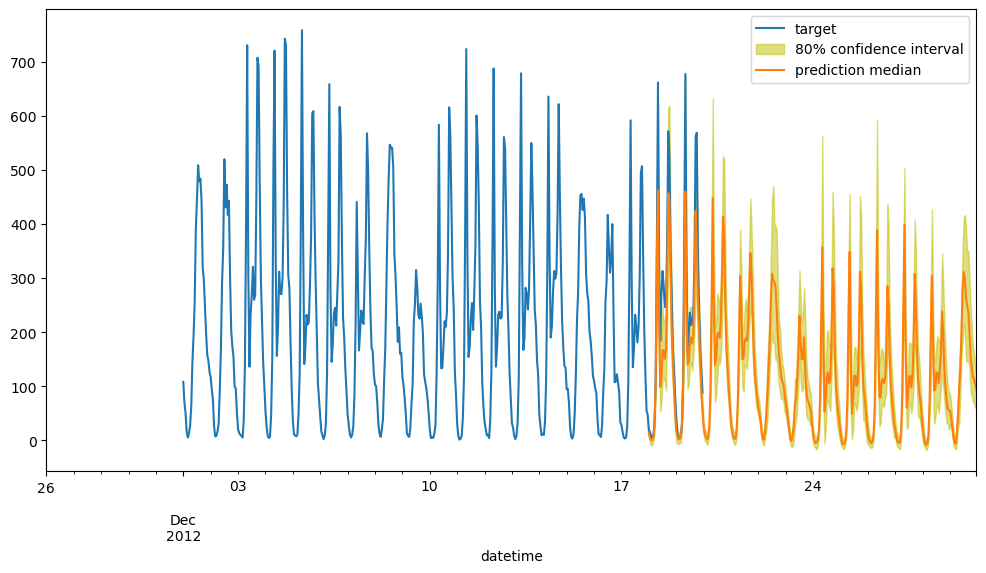

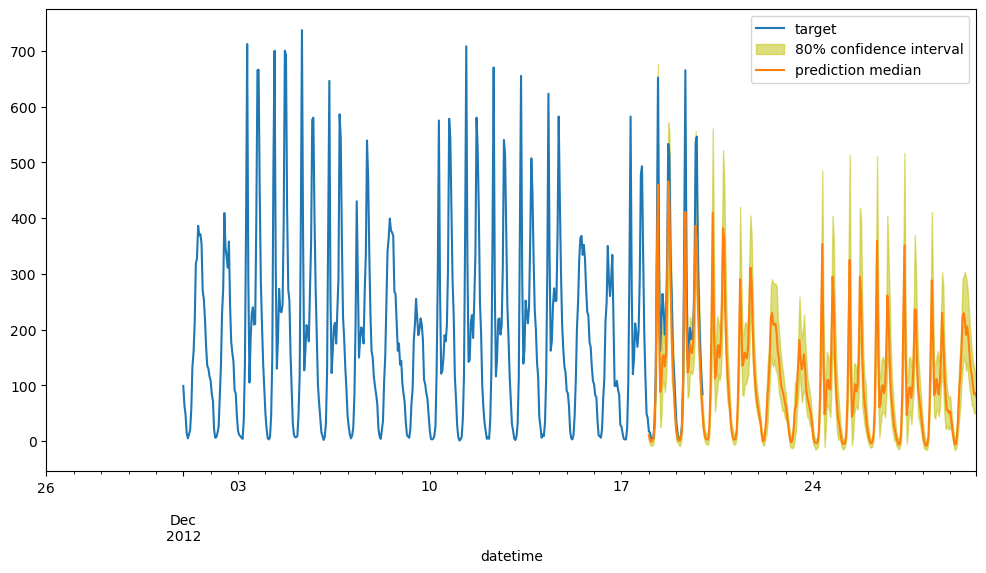

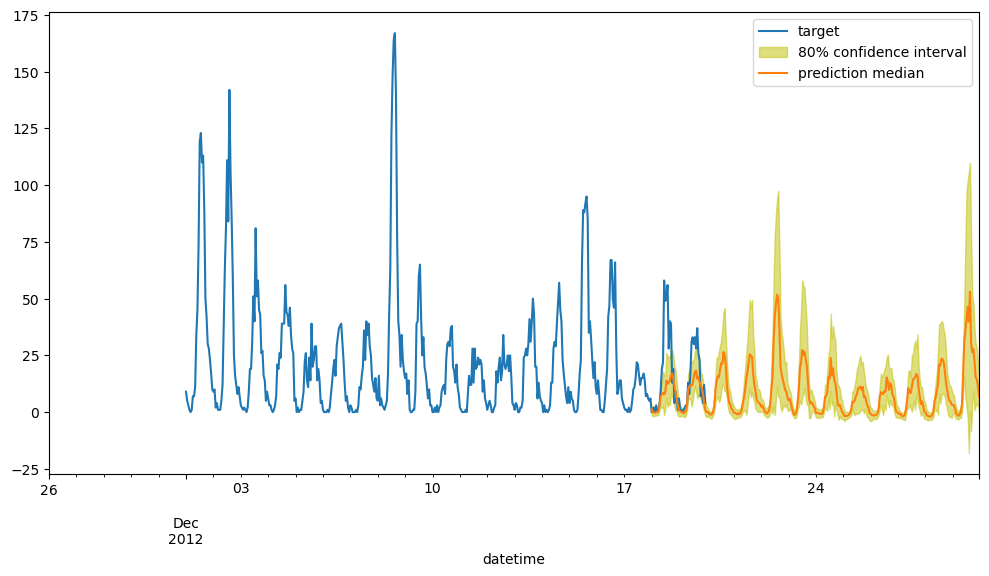

In [69]:
for k in range(len(list_of_df)):
    # print (-prediction_length-context_length) #120 = 72+48
    plt.figure(figsize=(12,6))
    
    time_series_test[k][-prediction_length-context_length:].plot(label='target')
    
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

In [70]:
predict_window=[]

In [71]:
for i,x in df_test.groupby([df_test.index.year, df_test.index.month]):
    predict_window.append(x.index.min()-datetime.timedelta(hours=1))

In [72]:
predict_window

[Timestamp('2011-01-19 23:00:00'),
 Timestamp('2011-02-19 23:00:00'),
 Timestamp('2011-03-19 23:00:00'),
 Timestamp('2011-04-19 23:00:00'),
 Timestamp('2011-05-19 23:00:00'),
 Timestamp('2011-06-19 23:00:00'),
 Timestamp('2011-07-19 23:00:00'),
 Timestamp('2011-08-19 23:00:00'),
 Timestamp('2011-09-19 23:00:00'),
 Timestamp('2011-10-19 23:00:00'),
 Timestamp('2011-11-19 23:00:00'),
 Timestamp('2011-12-19 23:00:00'),
 Timestamp('2012-01-19 23:00:00'),
 Timestamp('2012-02-19 23:00:00'),
 Timestamp('2012-03-19 23:00:00'),
 Timestamp('2012-04-19 23:00:00'),
 Timestamp('2012-05-19 23:00:00'),
 Timestamp('2012-06-19 23:00:00'),
 Timestamp('2012-07-19 23:00:00'),
 Timestamp('2012-08-19 23:00:00'),
 Timestamp('2012-09-19 23:00:00'),
 Timestamp('2012-10-19 23:00:00'),
 Timestamp('2012-11-19 23:00:00'),
 Timestamp('2012-12-19 23:00:00')]

In [73]:
for t in target_values:
    df_test[t] = np.nan

In [74]:
df_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,registered,casual
datetime,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,NaN,NaN,NaN
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,NaN,NaN,NaN
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,NaN,NaN,NaN
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,NaN,NaN,NaN
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,NaN,NaN,NaN


In [75]:
for window in predict_window:
    print(window)
    # If trained with categories, we need to send corresponding category for each training set
    # But in this case
    for i in range(len(target_values)):
        list_of_df = predictor.predict([time_series_test[i][:window]],
                                      cat=[i] if with_categories else None)
        
        df_tmp = list_of_df[0]
        df_tmp.index.name = 'datetime'
        df_tmp.columns = ['0.1', target_values[i],'0.9']
        df_test.update(df_tmp[target_values[i]])

2011-01-19 23:00:00
2011-02-19 23:00:00
2011-03-19 23:00:00
2011-04-19 23:00:00
2011-05-19 23:00:00
2011-06-19 23:00:00
2011-07-19 23:00:00
2011-08-19 23:00:00
2011-09-19 23:00:00
2011-10-19 23:00:00
2011-11-19 23:00:00
2011-12-19 23:00:00
2012-01-19 23:00:00
2012-02-19 23:00:00
2012-03-19 23:00:00
2012-04-19 23:00:00
2012-05-19 23:00:00
2012-06-19 23:00:00
2012-07-19 23:00:00
2012-08-19 23:00:00
2012-09-19 23:00:00
2012-10-19 23:00:00
2012-11-19 23:00:00
2012-12-19 23:00:00


In [76]:
df_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,registered,casual
datetime,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,12.849268,11.925821,0.866978
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,4.838300,3.848474,0.312899
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,1.845405,1.333676,0.116085
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,1.834191,0.579126,0.297788
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,0.988567,0.110442,-0.120657


In [77]:
df_test.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,registered,casual
datetime,,,,,,,,,,,
2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,307.804718,299.802124,12.703827
2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,201.363800,198.422241,8.960207
2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,140.800323,131.175278,8.270168
2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,98.716637,94.784096,6.930986
2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,67.024704,63.106800,4.307599


In [78]:
def adjust_count(x):
    if x<0:
        return 0
    else:
        return x

In [79]:
df_test['count'] = df_test['count'].map(adjust_count)

In [80]:
# Store the results
if with_categories:
    df_test[['count']].to_csv('prediction-with-categories.csv', index=True, index_label='datetime')
else:
    df_test[['count']].to_csv('prediction.csv',index=True, index_label='datetime')
    

In [81]:
# Delete the endpoint after completing
predictor.delete_endpoint()